## Running this notebook from top to bottom will download raw EMIT and ECOSTRESS data recorded concurrently in Los Angeles to your current working directory. The file losangeles.geojson must also be in this directory in order to run. It can be found in the emit-ecostress Google Drive under Data/01_Finding_Concurrent_Data_UrbanHeat/. The files we want downloaded as a result of running this notebook can also be found there.

In [ ]:
# # Uncomment and run this cell if on the Openscapes 2i2c Cloud Instance to install the scikit-image library
# !pip install scikit-image
!pip install earthaccess
!pip install mapclassify

# 01 Finding Concurrent ECOSTRESS and EMIT Data

---

**Summary**  

Both the ECOsystem Spaceborne Thermal Radiometer Experiment on Space Station (ECOSTRESS) and the Earth surface Mineral dust source InvesTigation (EMIT) instruments are located on the International Space Station (ISS). Their overlapping fields of view provide an unprecedented opportunity to demonstrate the compounded benefits of working with both datasets. In this notebook we will show how to utilize the [`earthaccess` Python library](https://github.com/nsidc/earthaccess) to find concurrent ECOSTRESS and EMIT data.

**Background**

The **ECOSTRESS** instrument is a multispectral thermal imaging radiometer designed to answer three overarching science questions:

- How is the terrestrial biosphere responding to changes in water availability?
- How do changes in diurnal vegetation water stress  the global carbon cycle?
- Can agricultural vulnerability be reduced through advanced monitoring of agricultural water consumptive use and improved drought   estimation?

The ECOSTRESS mission is answering these questions by accurately measuring the temperature of plants.  Plants regulate their temperature by releasing water through tiny pores on their leaves called stomata. If they have sufficient water they can maintain their temperature, but if there is insufficient water, their temperatures rise and this temperature rise can be measured with ECOSTRESS. The images acquired by ECOSTRESS are the most detailed temperature images of the surface ever acquired from space and can be used to measure the temperature of an individual farmers field.

More details about ECOSTRESS and its associated products can be found on the [ECOSTRESS website](https://ecostress.jpl.nasa.gov/) and [ECOSTRESS product pages](https://lpdaac.usgs.gov/product_search/?query=ECOSTRESS&status=Operational&view=cards&sort=title) hosted by the Land Processes Distributed Active Archive Center (LP DAAC).

The **EMIT** instrument is an imaging spectrometer that measures light in visible and infrared wavelengths. These measurements display unique spectral signatures that correspond to the composition on the Earth's surface. The EMIT mission focuses specifically on mapping the composition of minerals to better understand the effects of mineral dust throughout the Earth system and human populations now and in the future. In addition, the EMIT instrument can be used in other applications, such as mapping of greenhouse gases, snow properties, and water resources.

More details about EMIT and its associated products can be found on the [EMIT website](https://earth.jpl.nasa.gov/emit/) and [EMIT product pages](https://lpdaac.usgs.gov/product_search/?query=EMIT&status=Operational&view=cards&sort=title) hosted by the LP DAAC.

**Requirements**
 - *No requirements if connected to the workshop cloud instance!*
 - Set up Python Environment - See **setup_instructions.md** in the `/setup/` folder

**Learning Objectives**  
- How to use `earthaccess` to find concurrent EMIT and ECOSTRESS data.
- How to export a list of files and download them programatically.

**Tutorial Outline**  

1. Setup  
2. Searching for Data  
3. Organizing and Filtering Results
4. Visualizing Intersecting Coverage
5. Creating a list of Asset URLs and Downloading

---

## 1. Setup

Import the required Python libraries.

In [ ]:
# Import required libraries
import os
import folium
import earthaccess
import warnings
import folium.plugins
import pandas as pd
import geopandas as gpd
import math

import datetime

from branca.element import Figure
from IPython.display import display
from shapely import geometry
from skimage import io
from datetime import timedelta
from shapely.geometry.polygon import orient
from matplotlib import pyplot as plt

---
## 2. Search for ECOSTRESS and EMIT Data

Both EMIT and ECOSTRESS products are hosted by the Land Processes Distributed Active Archive Center (LP DAAC). In this example we will use the cloud-hosted EMIT_L2A_RFL and ECOSTRESS_L2T_LSTE products available from the LP DAAC to find data. Any results we find for these products, should be available for other products within the EMIT and ECOSTRESS collections.

To find data we will use the [`earthaccess` Python library](https://github.com/nsidc/earthaccess). `earthaccess` searches NASA's Common Metadata Repository (CMR), a metadata system that catalogs Earth Science data and associated metadata records. The results can then be used to download granules or generate lists granule search result URLs.

Using `earthaccess` we can search based on the attributes of a granule, which can be thought of as a spatiotemporal scene from an instrument containing multiple assets (eg. Reflectance, Reflectance Uncertainty, Masks for the EMIT L2A Reflectance Collection). We can search using attributes such as collection, acquisition time, and spatial footprint. This process can also be used with other EMIT or ECOSTRESS products, other collections, or different data providers, as well as across multiple catalogs with some modification.

### 2.1 Define Spatial Region of Interest

For this example, our spatial region of interest will be the Carpenteria Salt Marsh. You can learn more about it here: <https://ucnrs.org/reserves/carpinteria-salt-marsh-reserve/>. In this example, we elect to search using a polygon rather than a standard bounding box because bounding boxes will have a larger spatial extent, capturing many areas we may not be interested in. This becomes more important for searches with larger ROIs than our example here. To search for intersections with a polygon, we need to format our ROI as a counter-clockwise list of coordinate pairs.

Open the `geojson` file containing a landcover classification of our region of interest as a `geodataframe`, and check the coordinate reference system (CRS) of the data.

In [ ]:
os.getcwd()

'/content'

In [ ]:
#polygon = gpd.read_file('../data/landcover.geojson')
#polygon = gpd.read_file('../data/losangeles.geojson')
polygon = gpd.read_file('./losangeles.geojson')
polygon.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

The CRS is **EPSG:4326** (WGS84), which is also the CRS we want the data in to submit for our search.

Next, lets examine our polygon a bit closer.

In [ ]:
polygon

,geometry
0,"POLYGON ((-118.62221 34.27814, -118.34294 33.7..."


We can see this `geodataframe` consists of multiple classes, each containing a multipolygon within our study site. We need to create an exterior boundary polygon containing these, and make sure the vertices are in counter-clockwise order to submit them in our query. To do this, create a polygon consisting of all the geometries, then calculate the convex hull of the union. This will give us a simple exterior polygon around our full ROI. After that, use the `orient` function to place our coordinate pairs in counter-clockwise order.

In [ ]:
# Merge all Polygon geometries and create external boundary
roi_poly = polygon.unary_union.convex_hull
# Re-order vertices to counter-clockwise
roi_poly = orient(roi_poly, sign=1.0)

We can go ahead and visualize our region of interest and the original landcover polygon. First add a function to help reformat bound box coordinates to work with leaflet notation.

In [ ]:
# Function to convert a bounding box for use in leaflet notation

def convert_bounds(bbox, invert_y=False):
    """
    Helper method for changing bounding box representation to leaflet notation

    ``(lon1, lat1, lon2, lat2) -> ((lat1, lon1), (lat2, lon2))``
    """
    x1, y1, x2, y2 = bbox
    if invert_y:
        y1, y2 = y2, y1
    return ((y1, x1), (y2, x2))

Then create a figure using `folium`.

In [ ]:
fig = Figure(width="800px", height="400px")
map1 = folium.Map(tiles='https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}', attr='Google')
fig.add_child(map1)

# Add Convex Hull Polygon
folium.GeoJson(roi_poly,
                name='convex hull',
                ).add_to(map1)

# # Add landcover classification geodataframe
# polygon.explore(
#     "type",
#     popup=True,
#     categorical=True,
#     cmap='Set3',
#     style_kwds=dict(opacity=0.7, fillOpacity=0.4),
#     name="Carpenteria Salt Marsh Landcover",
#     m=map1
# )

map1.add_child(folium.LayerControl())
map1.fit_bounds(bounds=convert_bounds(polygon.unary_union.bounds))
display(fig)

Above we can see our region of interest (ROI) and the landcover classification polygon that we opened. We can hover over different areas to see the land cover class.

Lastly we need to convert our polygon to a list of coordinate pairs.

In [ ]:
# Set ROI as list of exterior polygon vertices as coordinate pairs
roi = list(roi_poly.exterior.coords)

### 2.2 Define Collections of Interest

We need to specify which products we want to search for using their short-names. As mentioned above, we will conduct our search using the EMIT Level 2A Reflectance (EMITL2ARFL) and ECOSTRESS Level 2 Tiled Land Surface Temperature and Emmissivity (ECO_L2T_LSTE).

>Note: Here we use the Tiled ECOSTRESS LSTE Product. This will also work with the gridded LSTE and the swath; however, the swath product does not have a browse image for the visualization in section 4, and will require additional processing for subsequent analysis.

In [ ]:
# Data Collections for our search
collections = ['EMITL2ARFL', 'ECO_L2T_LSTE']

### 2.3 Define Date Range

For our date range, we'll look at data collected across the month of April 2023. The `date_range` can be specified as a pair of dates, start and end (up to, not including).

In [ ]:
# Define Date Range
date_range = ('2023-07-01','2023-10-01')

### 2.4 Searching

Submit a query using `earthaccess`.

In [ ]:
results = earthaccess.search_data(
    short_name=collections,
    polygon=roi,
    temporal=date_range,
    count=500
)

Granules found: 130


In [ ]:
results

[Collection: {'ShortName': 'ECO_L2T_LSTE', 'Version': '002'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -119.17378006048253, 'EastBoundingCoordinate': -117.96980924294873, 'NorthBoundingCoordinate': 34.33773312439149, 'SouthBoundingCoordinate': 33.33312764840095}]}}}
 Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2023-07-01T08:55:34.839Z', 'EndingDateTime': '2023-07-01T08:56:26.805Z'}}
 Size(MB): 0.53
 Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_28264_003_11SLT_20230701T085534_0710_01/ECOv002_L2T_LSTE_28264_003_11SLT_20230701T085534_0710_01_water.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_28264_003_11SLT_20230701T085534_0710_01/ECOv002_L2T_LSTE_28264_003_11SLT_20230701T085534_0710_01_cloud.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_L

---

## 3. Organizing and Filtering Results

As we can see from above, the results object contains a list of objects with metadata and links. We can convert this to a more readable format, a dataframe. In addition, we can make it a geodataframe by taking the spatial metadata and creating a shapely polygon representing the spatial coverage, and further customize which information we want to use from other metadata fields.

First, we define some functions to help us create a shapely object for our geodataframe, and retrieve the specific browse image URLs that we want. By default the browse image selected by `earthaccess` is the first one in the list, but the ECO_L2_LSTE has several browse images and we want to make sure we retrieve the `png` file, which is a preview of the LSTE.

In [ ]:
# Function to create shapely polygon of spatial coverage
def get_shapely_object(result:earthaccess.results.DataGranule):
    # Get Geometry Keys
    geo = result['umm']['SpatialExtent']['HorizontalSpatialDomain']['Geometry']
    keys = geo.keys()

    if 'BoundingRectangles' in keys:
        bounding_rectangle = geo['BoundingRectangles'][0]
        # Create bbox tuple
        bbox_coords = (bounding_rectangle['WestBoundingCoordinate'],bounding_rectangle['SouthBoundingCoordinate'],
                    bounding_rectangle['EastBoundingCoordinate'],bounding_rectangle['NorthBoundingCoordinate'])
        # Create shapely geometry from bbox
        shape = geometry.box(*bbox_coords, ccw=True)
    elif 'GPolygons' in keys:
        points = geo['GPolygons'][0]['Boundary']['Points']
        # Create shapely geometry from polygons
        shape = geometry.Polygon([[p['Longitude'],p['Latitude']] for p in points])
    else:
         raise ValueError('Provided result does not contain bounding boxes/polygons or is incompatible.')
    return(shape)

# Retrieve png browse image if it exists or first jpg in list of urls
def get_png(result:earthaccess.results.DataGranule):
    https_links = [link for link in result.dataviz_links() if 'https' in link]
    if len(https_links) == 1:
        browse = https_links[0]
    elif len(https_links) == 0:
        browse = 'no browse image'
        warnings.warn(f"There is no browse imagery for {result['umm']['GranuleUR']}.")
    else:
        browse = [png for png in https_links if '.png' in png][0]
    return(browse)

Now that we have our functions we can create a dataframe, then calculate and add our shapely geometries to make a geodataframe. After that, add a column for our browse image urls and print the number of granules in our results, so we can monitor the quantity we  are working with a we winnow down to the data we want.

In [ ]:
# Create Dataframe of Results Metadata
results_df = pd.json_normalize(results)
# Create shapely polygons for result
geometries = [get_shapely_object(results[index]) for index in results_df.index.to_list()]
# Convert to GeoDataframe
gdf = gpd.GeoDataFrame(results_df, geometry=geometries, crs="EPSG:4326")
# Remove results df, no longer needed
del results_df
# Add browse imagery links
gdf['browse'] = [get_png(granule) for granule in results]
gdf['shortname'] = [result['umm']['CollectionReference']['ShortName'] for result in results]
# Preview GeoDataframe
print(f'{gdf.shape[0]} granules total')

130 granules total


Preview our geodataframe to get an idea what it looks like.

In [ ]:
gdf.head()

,size,meta.concept-type,meta.concept-id,meta.revision-id,meta.native-id,meta.provider-id,meta.format,meta.revision-date,umm.TemporalExtent.RangeDateTime.BeginningDateTime,umm.TemporalExtent.RangeDateTime.EndingDateTime,...,umm.Platforms,umm.MetadataSpecification.URL,umm.MetadataSpecification.Name,umm.MetadataSpecification.Version,umm.SpatialExtent.HorizontalSpatialDomain.Geometry.GPolygons,umm.PGEVersionClass.PGEName,umm.CloudCover,geometry,browse,shortname
0,0.53,granule,G2727990624-LPCLOUD,1,ECOv002_L2T_LSTE_28264_003_11SLT_20230701T0855...,LPCLOUD,application/echo10+xml,2023-07-06T22:45:53.762Z,2023-07-01T08:55:34.839Z,2023-07-01T08:56:26.805Z,...,"[{'ShortName': 'ISS', 'Instruments': [{'ShortN...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.5,UMM-G,1.6.5,NaN,NaN,NaN,"POLYGON ((-117.96981 33.33313, -117.96981 34.3...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,ECO_L2T_LSTE
1,11.88,granule,G2727990643-LPCLOUD,1,ECOv002_L2T_LSTE_28264_003_11SLU_20230701T0855...,LPCLOUD,application/echo10+xml,2023-07-06T22:45:58.621Z,2023-07-01T08:55:34.839Z,2023-07-01T08:56:26.805Z,...,"[{'ShortName': 'ISS', 'Instruments': [{'ShortN...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.5,UMM-G,1.6.5,NaN,NaN,NaN,"POLYGON ((-117.98003 34.23405, -117.98003 35.2...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,ECO_L2T_LSTE
2,13.18,granule,G2727156778-LPCLOUD,1,ECOv002_L2T_LSTE_28279_004_11SLU_20230702T0806...,LPCLOUD,application/echo10+xml,2023-07-06T04:26:10.848Z,2023-07-02T08:06:44.983Z,2023-07-02T08:07:36.953Z,...,"[{'ShortName': 'ISS', 'Instruments': [{'ShortN...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.5,UMM-G,1.6.5,NaN,NaN,NaN,"POLYGON ((-117.98003 34.23405, -117.98003 35.2...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,ECO_L2T_LSTE
3,13.46,granule,G2727156851-LPCLOUD,1,ECOv002_L2T_LSTE_28279_004_11SLT_20230702T0806...,LPCLOUD,application/echo10+xml,2023-07-06T04:26:21.221Z,2023-07-02T08:06:44.983Z,2023-07-02T08:07:36.953Z,...,"[{'ShortName': 'ISS', 'Instruments': [{'ShortN...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.5,UMM-G,1.6.5,NaN,NaN,NaN,"POLYGON ((-117.96981 33.33313, -117.96981 34.3...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,ECO_L2T_LSTE
4,19.21,granule,G2727158114-LPCLOUD,1,ECOv002_L2T_LSTE_28279_004_11SMT_20230702T0806...,LPCLOUD,application/echo10+xml,2023-07-06T04:26:58.088Z,2023-07-02T08:06:44.983Z,2023-07-02T08:07:36.953Z,...,"[{'ShortName': 'ISS', 'Instruments': [{'ShortN...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.5,UMM-G,1.6.5,NaN,NaN,NaN,"POLYGON ((-116.89432 33.34707, -116.89432 34.3...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,ECO_L2T_LSTE


There are a lot of columns with data that is not relevant to our goal, so we can drop those. To do that, list the names of colums.

In [ ]:
# List Column Names
gdf.columns

Index(['size', 'meta.concept-type', 'meta.concept-id', 'meta.revision-id',
       'meta.native-id', 'meta.provider-id', 'meta.format',
       'meta.revision-date',
       'umm.TemporalExtent.RangeDateTime.BeginningDateTime',
       'umm.TemporalExtent.RangeDateTime.EndingDateTime',
       'umm.OrbitCalculatedSpatialDomains', 'umm.GranuleUR',
       'umm.AdditionalAttributes', 'umm.MeasuredParameters',
       'umm.SpatialExtent.HorizontalSpatialDomain.Geometry.BoundingRectangles',
       'umm.ProviderDates', 'umm.CollectionReference.ShortName',
       'umm.CollectionReference.Version', 'umm.PGEVersionClass.PGEVersion',
       'umm.RelatedUrls', 'umm.DataGranule.DayNightFlag',
       'umm.DataGranule.Identifiers', 'umm.DataGranule.ProductionDateTime',
       'umm.DataGranule.ArchiveAndDistributionInformation', 'umm.Platforms',
       'umm.MetadataSpecification.URL', 'umm.MetadataSpecification.Name',
       'umm.MetadataSpecification.Version',
       'umm.SpatialExtent.HorizontalSpatialDo

Now create a list of columns to keep and use it to filter the dataframe.

In [ ]:
# Create a list of columns to keep
keep_cols = ['meta.concept-id','meta.native-id', 'umm.TemporalExtent.RangeDateTime.BeginningDateTime','umm.TemporalExtent.RangeDateTime.EndingDateTime','umm.CloudCover','umm.DataGranule.DayNightFlag','geometry','browse', 'shortname']
# Remove unneeded columns
gdf = gdf[gdf.columns.intersection(keep_cols)]
gdf.head()

,meta.concept-id,meta.native-id,umm.TemporalExtent.RangeDateTime.BeginningDateTime,umm.TemporalExtent.RangeDateTime.EndingDateTime,umm.DataGranule.DayNightFlag,umm.CloudCover,geometry,browse,shortname
0,G2727990624-LPCLOUD,ECOv002_L2T_LSTE_28264_003_11SLT_20230701T0855...,2023-07-01T08:55:34.839Z,2023-07-01T08:56:26.805Z,Night,NaN,"POLYGON ((-117.96981 33.33313, -117.96981 34.3...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,ECO_L2T_LSTE
1,G2727990643-LPCLOUD,ECOv002_L2T_LSTE_28264_003_11SLU_20230701T0855...,2023-07-01T08:55:34.839Z,2023-07-01T08:56:26.805Z,Night,NaN,"POLYGON ((-117.98003 34.23405, -117.98003 35.2...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,ECO_L2T_LSTE
2,G2727156778-LPCLOUD,ECOv002_L2T_LSTE_28279_004_11SLU_20230702T0806...,2023-07-02T08:06:44.983Z,2023-07-02T08:07:36.953Z,Night,NaN,"POLYGON ((-117.98003 34.23405, -117.98003 35.2...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,ECO_L2T_LSTE
3,G2727156851-LPCLOUD,ECOv002_L2T_LSTE_28279_004_11SLT_20230702T0806...,2023-07-02T08:06:44.983Z,2023-07-02T08:07:36.953Z,Night,NaN,"POLYGON ((-117.96981 33.33313, -117.96981 34.3...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,ECO_L2T_LSTE
4,G2727158114-LPCLOUD,ECOv002_L2T_LSTE_28279_004_11SMT_20230702T0806...,2023-07-02T08:06:44.983Z,2023-07-02T08:07:36.953Z,Night,NaN,"POLYGON ((-116.89432 33.34707, -116.89432 34.3...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,ECO_L2T_LSTE


This is looking better, but we can make it more readable by renaming our columns.

In [ ]:
# Rename some Columns
gdf.rename(columns = {'meta.concept-id':'concept_id','meta.native-id':'granule',
                       'umm.TemporalExtent.RangeDateTime.BeginningDateTime':'start_datetime',
                      'umm.TemporalExtent.RangeDateTime.EndingDateTime':'end_datetime',
                      'umm.CloudCover':'cloud_cover',
                      'umm.DataGranule.DayNightFlag':'day_night'}, inplace=True)
gdf.head()

,concept_id,granule,start_datetime,end_datetime,day_night,cloud_cover,geometry,browse,shortname
0,G2727990624-LPCLOUD,ECOv002_L2T_LSTE_28264_003_11SLT_20230701T0855...,2023-07-01T08:55:34.839Z,2023-07-01T08:56:26.805Z,Night,NaN,"POLYGON ((-117.96981 33.33313, -117.96981 34.3...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,ECO_L2T_LSTE
1,G2727990643-LPCLOUD,ECOv002_L2T_LSTE_28264_003_11SLU_20230701T0855...,2023-07-01T08:55:34.839Z,2023-07-01T08:56:26.805Z,Night,NaN,"POLYGON ((-117.98003 34.23405, -117.98003 35.2...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,ECO_L2T_LSTE
2,G2727156778-LPCLOUD,ECOv002_L2T_LSTE_28279_004_11SLU_20230702T0806...,2023-07-02T08:06:44.983Z,2023-07-02T08:07:36.953Z,Night,NaN,"POLYGON ((-117.98003 34.23405, -117.98003 35.2...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,ECO_L2T_LSTE
3,G2727156851-LPCLOUD,ECOv002_L2T_LSTE_28279_004_11SLT_20230702T0806...,2023-07-02T08:06:44.983Z,2023-07-02T08:07:36.953Z,Night,NaN,"POLYGON ((-117.96981 33.33313, -117.96981 34.3...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,ECO_L2T_LSTE
4,G2727158114-LPCLOUD,ECOv002_L2T_LSTE_28279_004_11SMT_20230702T0806...,2023-07-02T08:06:44.983Z,2023-07-02T08:07:36.953Z,Night,NaN,"POLYGON ((-116.89432 33.34707, -116.89432 34.3...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,ECO_L2T_LSTE


> **Note: If querying on-premises (not cloud) LP DAAC datasets, the `meta.concept-id` will not show as `xxxxxx-LPCLOUD`. For these datasets, the granule name can be retrieved from the `umm.DataGranule.Identifiers` column.**

We can filter using the day/night flag as well, but this step will be unnecessary as we check to ensure all results from ECOSTRESS fall within an hour of resulting EMIT granules.

In [ ]:
# gdf = gdf[gdf['day_night'].str.contains('Day')]

Our first step toward filtering the datasets will be to add a a column with a `datetime`. You may have noticed that the date format is similar for ECOSTRESS and EMIT, but the ECOSTRESS data has an additional fractional seconds. To account for this discrepancy, pass the `format='ISO8601'`argument to the `to_datetime` function.

In [ ]:
gdf['datetime_obj'] = pd.to_datetime(gdf['start_datetime'], format='%Y-%m-%dT%H:%M:%S.%f')

In [ ]:
gdf.datetime_obj

0     2023-07-01 08:55:34.839000+00:00
1     2023-07-01 08:55:34.839000+00:00
2     2023-07-02 08:06:44.983000+00:00
3     2023-07-02 08:06:44.983000+00:00
4     2023-07-02 08:06:44.983000+00:00
                    ...               
125   2023-09-24 22:33:06.558000+00:00
126   2023-09-26 05:53:50.249000+00:00
127   2023-09-26 05:53:50.249000+00:00
128   2023-09-28 20:57:26.243000+00:00
129   2023-09-28 20:57:26.243000+00:00
Name: datetime_obj, Length: 130, dtype: datetime64[ns, UTC]

We can roughly visualize the quantity of results by month at our location using a histogram with 8 bins (Jan up to Sept).

array([<Axes: title={'center': 'ECO_L2T_LSTE'}>,
       <Axes: title={'center': 'EMITL2ARFL'}>], dtype=object)

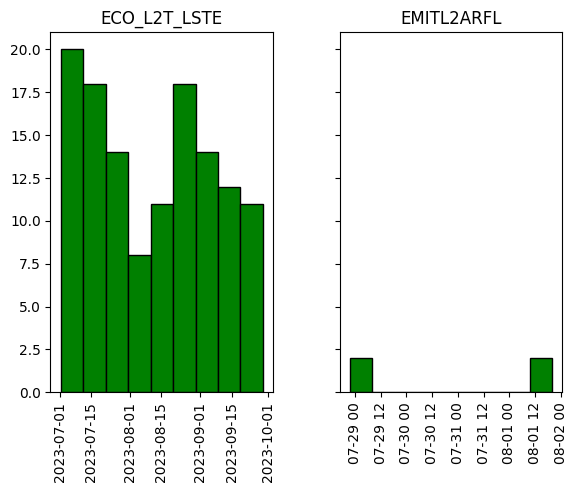

In [ ]:
gdf.hist(column='datetime_obj', by='shortname', bins=9, color='green', edgecolor='black', linewidth=1, sharey=True)

Now we will separate the results into two dataframes, one for ECOTRESS and one for EMIT and print the number of results for each so we can monitor how many granules we're filtering.

In [ ]:
# Suppress Setting with Copy Warning - not applicable in this use case
pd.options.mode.chained_assignment = None  # default='warn'

# Split into two dataframes - ECO and EMIT
eco_gdf = gdf[gdf['granule'].str.contains('ECO')]
emit_gdf = gdf[gdf['granule'].str.contains('EMIT')]
print(f' ECOSTRESS Granules: {eco_gdf.shape[0]} \n EMIT Granules: {emit_gdf.shape[0]}')

 ECOSTRESS Granules: 126 
 EMIT Granules: 4


In [ ]:
emit_gdf.head()

,concept_id,granule,start_datetime,end_datetime,day_night,cloud_cover,geometry,browse,shortname,datetime_obj
49,G2741060356-LPCLOUD,EMIT_L2A_RFL_001_20230728T214106_2320914_002,2023-07-28T21:41:06Z,2023-07-28T21:41:18Z,Day,44.0,"POLYGON ((-118.07111 34.29493, -118.83492 33.6...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,EMITL2ARFL,2023-07-28 21:41:06+00:00
50,G2741066142-LPCLOUD,EMIT_L2A_RFL_001_20230728T214118_2320914_003,2023-07-28T21:41:18Z,2023-07-28T21:41:30Z,Day,22.0,"POLYGON ((-117.42510 34.80747, -118.19991 34.1...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,EMITL2ARFL,2023-07-28 21:41:18+00:00
56,G2745980964-LPCLOUD,EMIT_L2A_RFL_001_20230801T200434_2321313_001,2023-08-01T20:04:34Z,2023-08-01T20:04:46Z,Day,6.0,"POLYGON ((-117.74358 33.96697, -118.49446 33.3...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,EMITL2ARFL,2023-08-01 20:04:34+00:00
57,G2745929345-LPCLOUD,EMIT_L2A_RFL_001_20230801T200446_2321313_002,2023-08-01T20:04:46Z,2023-08-01T20:04:58Z,Day,27.0,"POLYGON ((-117.10063 34.48273, -117.86653 33.8...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,EMITL2ARFL,2023-08-01 20:04:46+00:00


We still haven't filtered the locations where EMIT and ECOSTRESS have data at the same spatial location and time-frame. The EMIT acquisition mask has been added to ECOSTRESS, so in most cases if EMIT is collecting data, so will ECOSTRESS, but there are edge cases where this is not true.  To do this we'll use two filters to catch the edge-cases, and provide an example that can be used with other datasets.

First, since EMIT has a smaller swath width, we can can use a unary union of the spatial coverage present in our geodataframe to filter out ecostress granules that do not overlap with it.

In [ ]:
# Subset ECOSTRESS Granules in Geodataframe by intersection with EMIT granules
## Create new column based on intersection with union of EMIT polygons.
eco_gdf['intersects'] = eco_gdf.intersects(emit_gdf.unary_union)
## Apply subsetting
eco_gdf = eco_gdf[eco_gdf['intersects'] == True]
print(f' ECOSTRESS Granules: {eco_gdf.shape[0]} \n EMIT Granules: {emit_gdf.shape[0]}')

 ECOSTRESS Granules: 126 
 EMIT Granules: 4


In this instance, our results aren't narrowed because our region of interest is smaller than a single EMIT scene. If the spatial ROI was very large, this would be much more unlikely.

Additionally, we want to make sure that data in our results are collected at the same time. For EMIT and ECOSTRESS, the EMIT acquisition mask has been added to the ECOSTRESS mask, meaning that if there is an EMIT scene, there should also be an ECOSTRESS scene acquired at the same time. In practice, however, the timestamps on the scenes can vary slightly. In order to capture this slight variability,  we need to use a range instead of a single timestamp to capture concurrent data. To do this, we'll ensure all ECOSTRESS granule start times fall within 10 minutes of any of the EMIT granules in our results, and vice-versa.


Write a function to evaluate whether these `datetime` objects fall within 10 minutes of one another using the `timedelta` function.

In [ ]:
# Function to Filter timestamps that do not fall within a time_delta of timestamps from the other acquisition time
def concurrent_match(gdf_a:pd.DataFrame, gdf_b:pd.DataFrame, col_name:str, time_delta:timedelta):
    """
    Cross references dataframes containing a datetime object column and keeps rows in
    each that fall within the provided timedelta of the other. Acceptable time_delta examples:

    months=1
    days=1
    hours=1
    minutes=1
    seconds=1

    """
    # Match Timestamps from Dataframe A with Time-range of entries in Dataframe B
    # Create empty list
    a_list = []
    # Iterate results for product a based on index values
    for _n in gdf_b.index.to_list():
        # Find where product b is within the window of each product a result
        a_matches = (gdf_a[col_name] > gdf_b[col_name][_n]-time_delta) & (gdf_a[col_name] < gdf_b[col_name][_n]+time_delta)
        # Append list with values
        a_list.append(a_matches)
    # Match Timestamps from Dataframe B with Time-range of entries in Dataframe A
    # Create empy list
    b_list =[]
    for _m in gdf_a.index.to_list():
        # Find where product a is within the window of each product b result
        b_matches = (gdf_b[col_name] > gdf_a[col_name][_m]-time_delta) &  (gdf_b[col_name] < gdf_a[col_name][_m]+time_delta)
        # Append list with values
        b_list.append(b_matches)
    # Filter Original Dataframes by summing list of bools, 0 = outside of all time-ranges
    a_filtered = gdf_a.loc[sum(a_list) > 0]
    b_filtered = gdf_b.loc[sum(b_list) > 0]
    return(a_filtered, b_filtered)

Now run our function.

In [ ]:
eco_gdf, emit_gdf = concurrent_match(eco_gdf,emit_gdf, col_name='datetime_obj',time_delta=timedelta(minutes=10))
print(f' ECOSTRESS Granules: {eco_gdf.shape[0]} \n EMIT Granules: {emit_gdf.shape[0]}')

 ECOSTRESS Granules: 3 
 EMIT Granules: 2


---
## 4. Visualizing Intersecting Coverage

Now that we have geodataframes containing some concurrent data, we can visualize them on a map using `folium`. It's often difficult to visualize a large time-series of scenes, so we've included an example in Appendix A1 on how to filter to a single day.

In [ ]:
# Plot Using Folium

# Create Figure and Select Background Tiles
fig = Figure(width="1100px", height="550px")
map1 = folium.Map(tiles='https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}', attr='Google')
fig.add_child(map1)

# Plot STAC ECOSTRESS Results - note we must drop the datetime_obj columns for this to work
eco_gdf.drop(columns=['datetime_obj']).explore(
    "granule",
    categorical=True,
    tooltip=[
        "granule",
        "start_datetime",
        "cloud_cover",
    ],
    popup=True,
    style_kwds=dict(fillOpacity=0.1, width=2),
    name="ECOSTRESS",
    m=map1,
)

# Plot STAC EMITL2ARFL Results - note we must drop the datetime_obj columns for this to work
emit_gdf.drop(columns=['datetime_obj']).explore(
    "granule",
    categorical=True,
    tooltip=[
        "granule",
        "start_datetime",
        "cloud_cover",
    ],
    popup=True,
    style_kwds=dict(fillOpacity=0.1, width=2),
    name="EMIT",
    m=map1,
)

# ECOSTRESS Browse Images - Comment out to remove
for _n in eco_gdf.index.to_list():
    folium.raster_layers.ImageOverlay(
        image=eco_gdf['browse'][_n],
        name=eco_gdf['granule'][_n],
        bounds=[[eco_gdf.bounds['miny'][_n], eco_gdf.bounds['minx'][_n]], [eco_gdf.bounds['maxy'][_n], eco_gdf.bounds['maxx'][_n]]],
        interactive=False,
        cross_origin=False,
        opacity=0.75,
        zindex=1,
        ).add_to(map1)

# Plot Region of Interest
polygon.explore(
    popup=False,
    style_kwds=dict(fillOpacity=0.1, width=2),
    name="Region of Interest",
    m=map1
)

map1.fit_bounds(bounds=convert_bounds(gdf.unary_union.bounds))
map1.add_child(folium.LayerControl())
display(fig)

In the figure above, you can zoom in and out, click and drag to reposition the legend, and add or remove layers using the layer control in the top right. Notice that since we're using the tiled ecostress product, we have 2 overlapping tiles at our ROI. You can visualize the tiles by adding or removing the layers.

### 4.2 Previewing EMIT Browse Imagery
The EMIT browse imagery is not orthorectified, so it can't be visualized on a plot like the ECOSTRESS browse imagery. To get an idea what scenes look like we can plot them in a grid using matplotlib.

> Note: The black space is indicative of onboard cloud masking that occurs before data is downlinked from the ISS.

<function matplotlib.pyplot.show(close=None, block=None)>

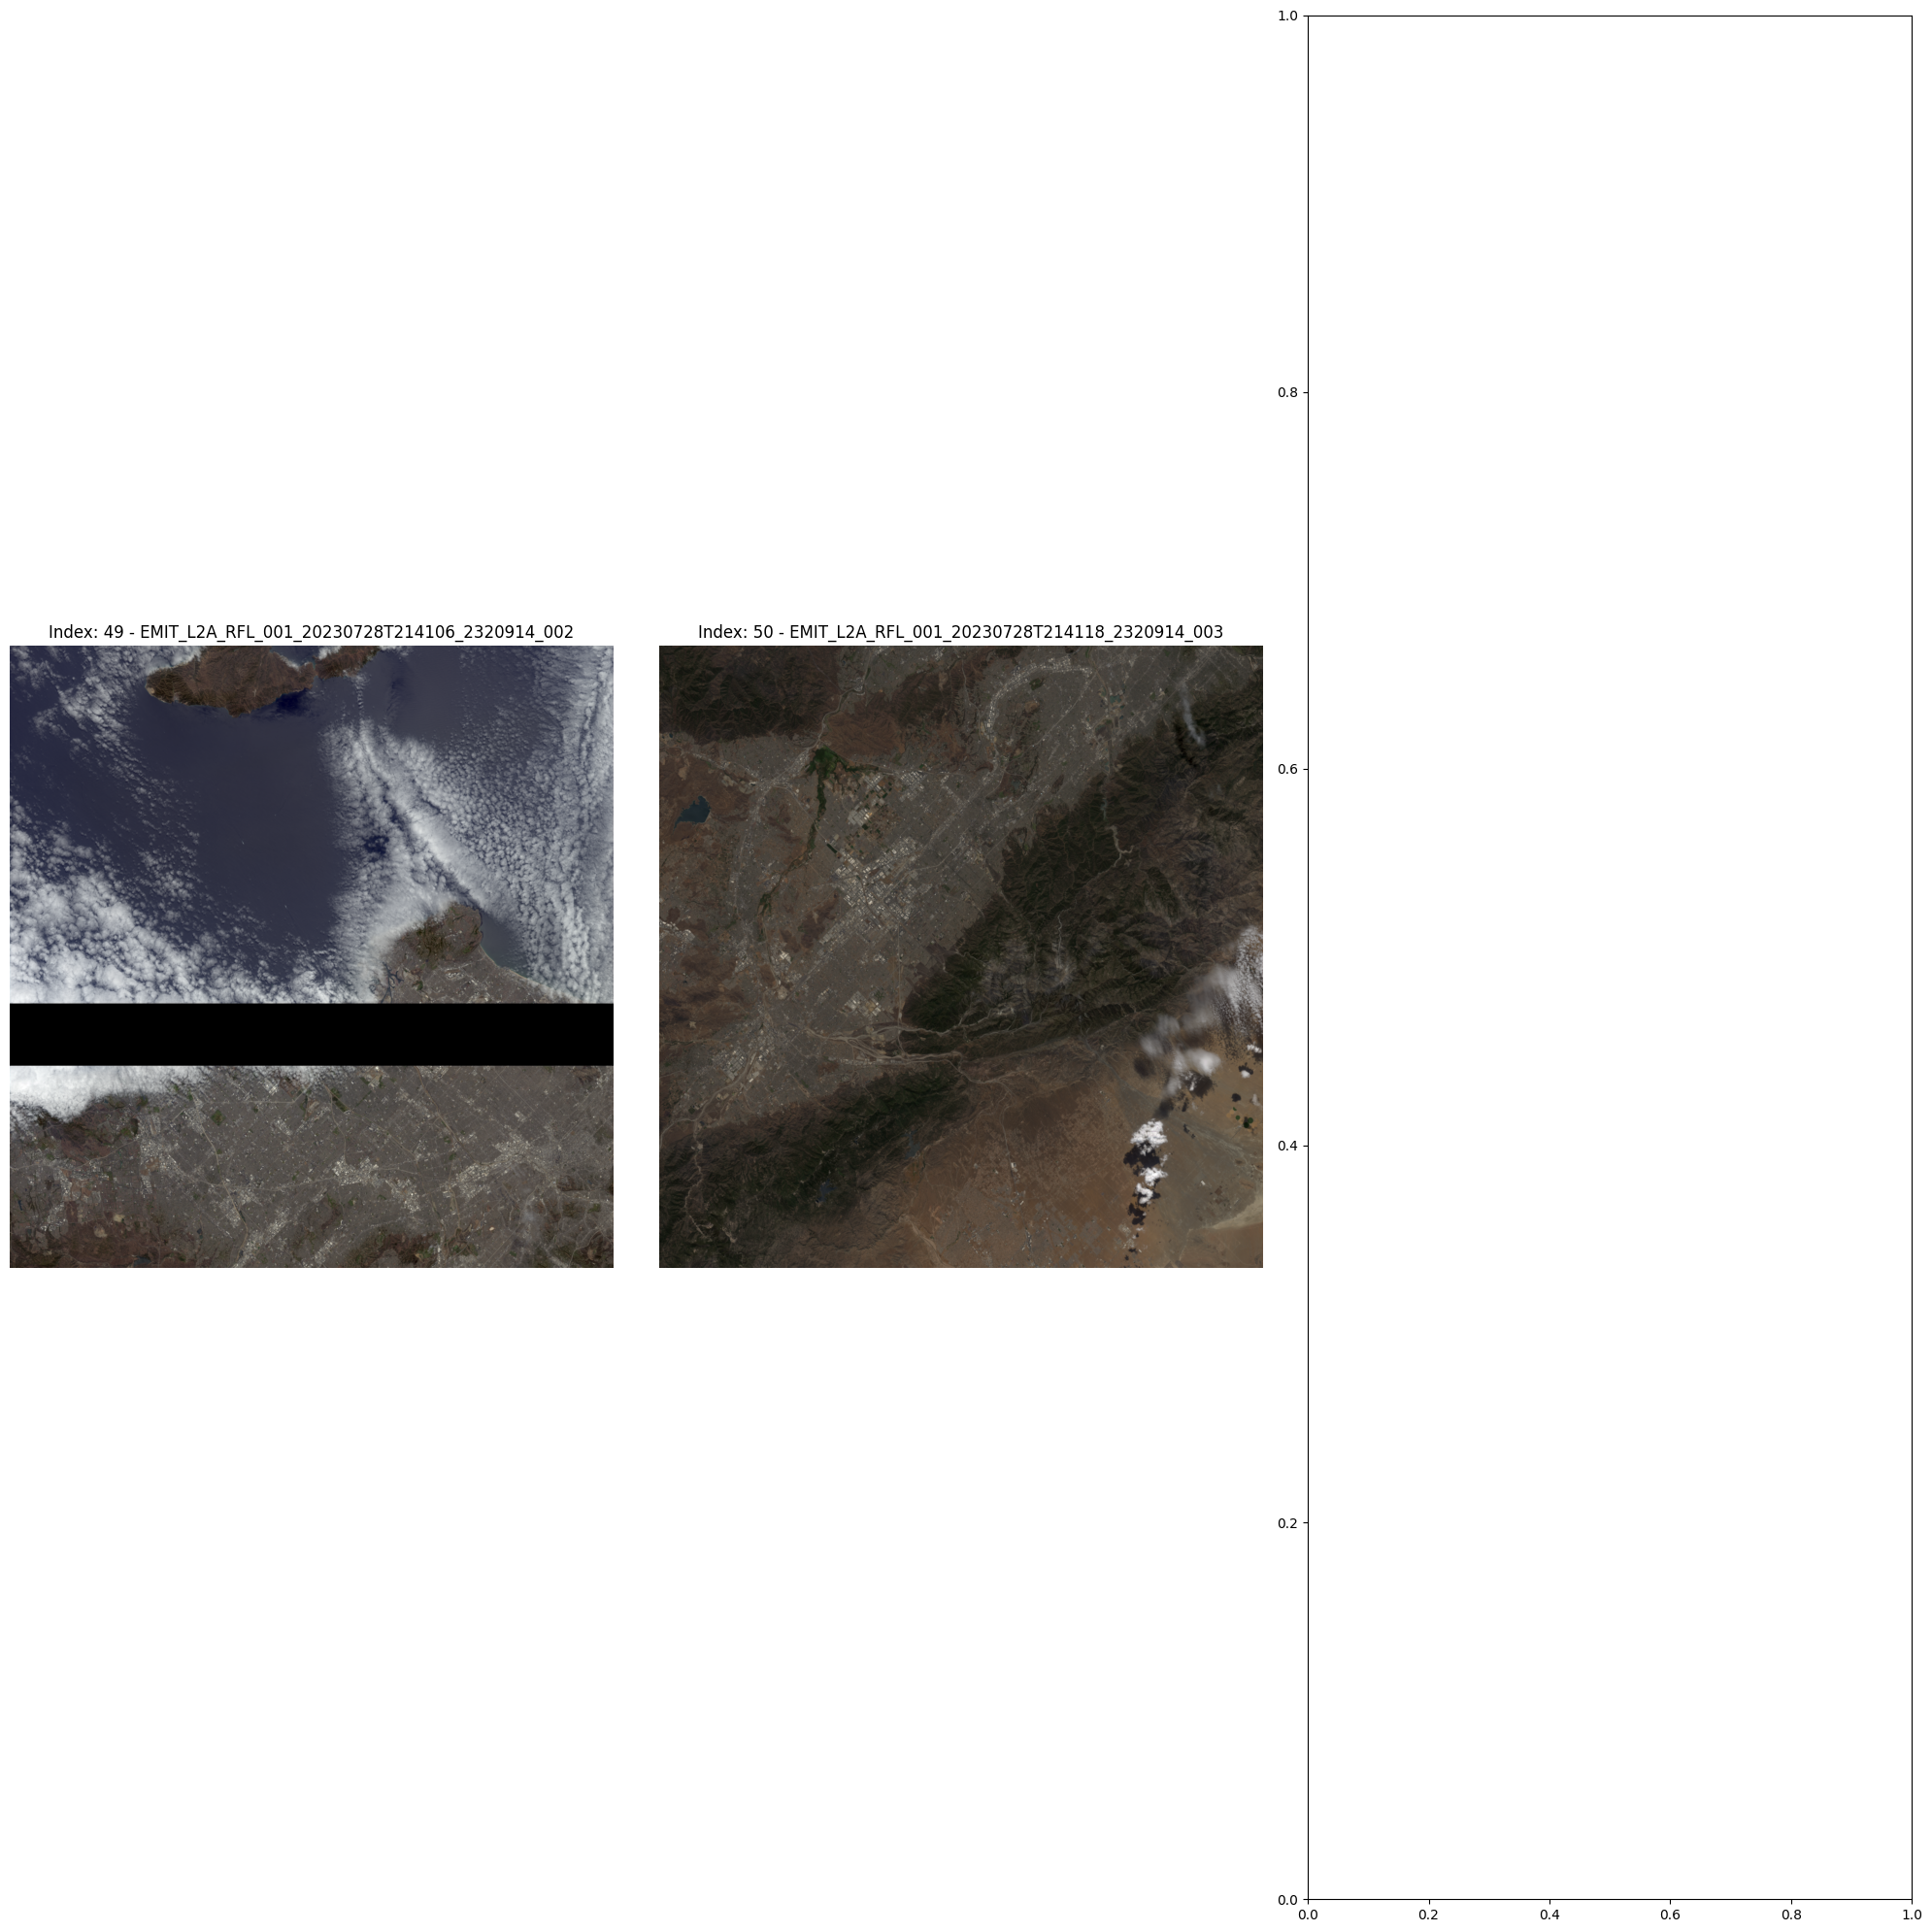

In [ ]:
cols = 3
rows = math.ceil(len(emit_gdf)/cols)
fig, ax = plt.subplots(rows, cols, figsize=(20,20))
ax = ax.flatten()

for _n, index in enumerate(emit_gdf.index.to_list()):
    img = io.imread(emit_gdf['browse'][index])
    ax[_n].imshow(img)
    ax[_n].set_title(f"Index: {index} - {emit_gdf['granule'][index]}")
    ax[_n].axis('off')
plt.tight_layout()
plt.show

### 4.3 Further Filtering

We can see that some of these granules likely won't work because of the large amount of cloud cover, we can use a list of these to filter them out. Make a list of indexes to filter out.

In [ ]:
# Bad granule list
bad_granules = [27,74,87]

In [ ]:
import numpy as np

Filter out the bad granules.

In [ ]:
emit_gdf = emit_gdf[~emit_gdf.index.isin(bad_granules)]

Now that we've narrowed our EMIT results we can again filter the ecostress granules based on their concurrency with our filtered EMIT granules.

In [ ]:
eco_gdf, emit_gdf = concurrent_match(eco_gdf,emit_gdf, col_name='datetime_obj',time_delta=timedelta(hours=1))
print(f' ECOSTRESS Granules: {eco_gdf.shape[0]} \n EMIT Granules: {emit_gdf.shape[0]}')

 ECOSTRESS Granules: 3 
 EMIT Granules: 2


---

## 5. Generating a list of URLs and downloading data

Creating a list of results URLs will include all of these assets, so if we only want a subset we need an additional filter to keep the specific assets we want.

If you look back, you can see we kept the same indexing throughout the notebook. This enables us to simply subset the `earthaccess` results object to retrieve the results we want.

Create a list of index values to keep.

In [ ]:
keep_granules = eco_gdf.index.to_list()+emit_gdf.index.to_list()
keep_granules.sort()

Filter the results list.

In [ ]:
filtered_results = [result for i, result in enumerate(results) if i in keep_granules]

Now we can download all of the associated assets, or retrieve the URLS and further filter them to specifically what we want.

In [ ]:
# Download All Assets for Granules in Filtered Results
earthaccess.login(persist=True)
earthaccess.download(filtered_results, '.')

Or we can create a list of URLs and use that to further refine which files we download.

In [ ]:
# Retrieve URLS for Assets
# results_urls = [granule.data_links() for granule in filtered_results]

Granules often have several assets associated with them, for example, `ECO_L2T_LSTE` has several assets:
 - Water Mask (water)
 - Cloud Mask (cloud)
 - Quality (QC)
 - Land Surface Temperature (LST)
 - Land Surface Temperature Error (LST_err)
 - Wide Band Emissivity (EmisWB)
 - Height (height)

The results list we just generated contains URLs to all of these files. We can further filter our results list using string matching to remove unwanted assets.

Create a list of strings and enumerate through our results_url list to filter out unwanted assets.

In [ ]:
# filtered_asset_links = []
# # Pick Desired Assets (leave _ on RFL to distinguish from RFLUNC, LST. to distinguish from LST_err)
# desired_assets = ['RFL_', 'LST.'] # Add more or do individually for reflectance, reflectance uncertainty, or mask
# # Step through each sublist (granule) and filter based on desired assets.
# for n, granule in enumerate(results_urls):
#     for url in granule:
#         asset_name = url.split('/')[-1]
#         if any(asset in asset_name for asset in desired_assets):
#             filtered_asset_links.append(url)
# filtered_asset_links

['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_28691_004_11SLT_20230728T214058_0710_01/ECOv002_L2T_LSTE_28691_004_11SLT_20230728T214058_0710_01_LST.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_28691_004_11SLU_20230728T214058_0710_01/ECOv002_L2T_LSTE_28691_004_11SLU_20230728T214058_0710_01_LST.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_28691_004_11SMT_20230728T214058_0710_01/ECOv002_L2T_LSTE_28691_004_11SMT_20230728T214058_0710_01_LST.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2ARFL.001/EMIT_L2A_RFL_001_20230728T214106_2320914_002/EMIT_L2A_RFL_001_20230728T214106_2320914_002.nc',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2ARFL.001/EMIT_L2A_RFL_001_20230728T214118_2320914_003/EMIT_L2A_RFL_001_20230728T214118_2320914_003.nc']

Uncomment the cell below (select all, then ctrl+/) and use your NASA Earthdata Login to sign in and download the data that we've filtered.

In [ ]:
# # Get Https Session using Earthdata Login Info
# earthaccess.login()
# fs = earthaccess.get_fsspec_https_session()
# # Retrieve granule asset ID from URL (to maintain existing naming convention)
# for url in filtered_asset_links:
#     granule_asset_id = url.split('/')[-1]
#     # Define Local Filepath
#     fp = f'../data/{granule_asset_id}'
#     # Download the Granule Asset if it doesn't exist
#     if not os.path.isfile(fp):
#         fs.download(url, fp)

We are already authenticated with NASA EDL


Congratulations, now you have downloaded concurrent data from the ECOSTRESS and EMIT instruments on the ISS.

---

## Contact Info:  

Email: LPDAAC@usgs.gov  
Voice: +1-866-573-3222  
Organization: Land Processes Distributed Active Archive Center (LP DAAC)¹  
Website: <https://lpdaac.usgs.gov/>  
Date last modified: 09-27-2023  

¹Work performed under USGS contract G15PD00467 for NASA contract NNG14HH33I.

---

## Appendices

These contain some extra code that may be useful when performing a similar workflow.

### A1. Further Limiting Search for Visualization Purposes

A large quantity of results may be difficult to understand when mapping with folium. We can create a subset that falls within a single day. First add another column of dates only, then find the unique dates.


In [ ]:
# eco_gdf['date'] = eco_gdf['start_datetime'].str.split('T').str[0]
# emit_gdf['date'] = emit_gdf['start_datetime'].str.split('T').str[0]
# emit_gdf['date'].unique()

Filter both sets of results using a single date.

In [ ]:
# single_day_eco = eco_gdf#[eco_gdf['date'] == '2023-04-23']
# single_day_emit = emit_gdf#[emit_gdf['date'] == '2023-04-23']
# print(f' ECOSTRESS Granules: {single_day_eco.shape[0]} \n EMIT Granules: {single_day_emit.shape[0]}')



### A2. Convert Shapefile to GeoJSON

We can convert a shapefile to a geojson using the following cell. Note that we need to reorder the polygon external vertices so we can submit them as a list of points for our search.

In [ ]:
# # Use Sedgwick Reserve Shapefile
# # Open Shapefile
# polygon = gpd.read_file('../data/Sedgwick_Boundary/Sedgwick_Boundary.shp').to_crs("EPSG:4326")
# # Reorder vertices into Counter-clockwise order
# polygon.geometry[0] = orient(polygon.geometry[0], sign=1.0)
# # Save as a geojson (not necessary)
# polygon.to_file('../data/sedgwick_boundary_epsg4326.geojson', driver='GeoJSON')